### Required Packages

In [1]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [2]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head(5)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency_K_pop_numeric,Frequency_Latin_numeric,Frequency_Lofi_numeric,Frequency_Metal_numeric,Frequency_Pop_numeric,Frequency_R&B_numeric,Frequency_Rap_numeric,Frequency_Rock_numeric,Frequency_Video_game_music_numeric,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,3,3,1,0,3,2,3,0,2,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,1,2,1,0,2,2,1,3,1,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,3,0,2,2,1,0,1,1,3,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,2,3,2,0,2,2,0,0,0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,3,2,2,0,2,3,3,0,1,10


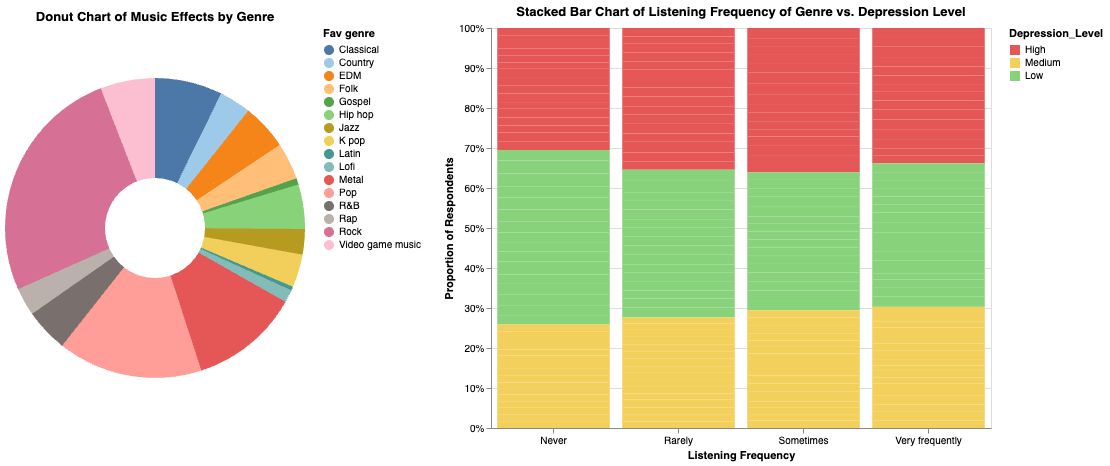

In [3]:
# Group data for Donut Chart
data_grouped_donut = mxmh.groupby(['Fav genre', 'Music effects']).size().reset_index(name='Count')

# Define available options for Music Effects filter
music_effects_options = list(data_grouped_donut["Music effects"].unique())
music_effects_options.insert(0, "All")  # Add 'All' as the first option

# Reshape data for Bar Chart
genre_columns = [
    'Frequency_Classical', 'Frequency_Country', 'Frequency_EDM', 'Frequency_Folk',
    'Frequency_Gospel', 'Frequency_Hip_hop', 'Frequency_Jazz', 'Frequency_K_pop',
    'Frequency_Latin', 'Frequency_Lofi', 'Frequency_Metal', 'Frequency_Pop',
    'Frequency_R&B', 'Frequency_Rap', 'Frequency_Rock', 'Frequency_Video_game_music'
]

melted_data = mxmh.melt(id_vars=["Depression_Level"], value_vars=genre_columns,
                        var_name="Fav genre", value_name="Frequency")
melted_data['Fav genre'] = melted_data['Fav genre'].str.replace('Frequency_', '', regex=False).str.replace('_', ' ')

data_grouped_bar = melted_data.groupby(['Fav genre', 'Frequency', 'Depression_Level'], observed=False).size().reset_index(name='Count')
group_sums = data_grouped_bar.groupby(['Fav genre', 'Frequency'], observed=False)['Count'].transform('sum')
data_grouped_bar['Proportion'] = data_grouped_bar['Count'] / group_sums

# Dropdown Filter for 'Music effects'
music_effect_dropdown = alt.binding_select(
    options=music_effects_options,
    name="Select Music Effect: "
)
music_effect_selection = alt.param(name="MusicEffectSelection", bind=music_effect_dropdown, value="All")

genre_selection = alt.selection_point(fields=["Fav genre"], name="GenreSelection", empty='all')
depr_selection = alt.selection_point(fields=["Depression_Level"], name="DepressionSelection", empty='all')


donut_chart = alt.Chart(data_grouped_donut).mark_arc(innerRadius=50).encode(
    theta='Count:Q',
    color=alt.Color('Fav genre:N').scale(scheme="tableau20"),
    tooltip=['Fav genre:N', 'Count:Q'],
    opacity=alt.condition(genre_selection, alt.value(1), alt.value(0.2))
).transform_filter(
    (alt.datum["Music effects"] == music_effect_selection) | (music_effect_selection == "All")
).add_params(
    music_effect_selection, genre_selection
).properties(
    width=300, height=400, title="Donut Chart of Music Effects by Genre"
)

# Stacked Bar Chart
bar_chart = alt.Chart(data_grouped_bar).mark_bar().encode(
    x=alt.X('Frequency:N', title="Listening Frequency", axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Proportion:Q', title="Proportion of Respondents", stack='normalize', sort=['High', 'Medium', 'Low']), 
      color=alt.Color(
        'Depression_Level:N',
         scale=alt.Scale(domain=['High', 'Medium', 'Low'], range=['#E45756', '#F2D05B', '#88D27B']), 
          sort=['High', 'Medium', 'Low']),
    tooltip=['Fav genre:N', 'Frequency:N', 'Depression_Level:N', 'Proportion:Q'],
    opacity=alt.condition(depr_selection, alt.value(1), alt.value(0.2))
).transform_filter(
    genre_selection
).add_params(
    genre_selection, depr_selection
).properties(
    title="Stacked Bar Chart of Listening Frequency of Genre vs. Depression Level",
    width=500, height=400
)

vis1_vis2_chart = alt.hconcat(
    donut_chart, bar_chart
).resolve_scale(
    color='independent'
)

vis1_vis2_chart

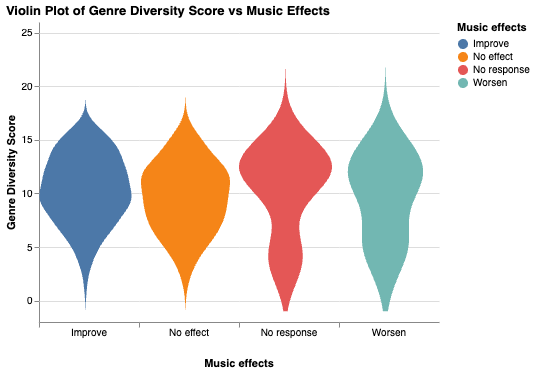

In [4]:
interactive_legend = alt.selection_point(
    fields=['Music effects'],  
    bind='legend',             
)

# Create an interval selection for the range slider
range_slider = alt.selection_interval(
    encodings=['y'],  
    bind='scales', 
    name='RangeSlider'  
)

# Create the violin plot chart
task_2_chart = alt.Chart(mxmh).transform_filter(
    range_slider  # Filter data based on the range slider selection
).transform_density(
    'Genre Diversity Score',
    as_=['Genre Diversity Score', 'density'],
    extent=[-1, 25],  # Keep the extent consistent
    groupby=['Music effects']
).mark_area(orient='horizontal').encode(
    y=alt.Y('Genre Diversity Score:Q', title="Genre Diversity Score"),
    color=alt.Color('Music effects:N').scale(scheme="tableau10"),
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
    ),
    column=alt.Column(
        'Music effects:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    ),
    opacity=alt.condition(interactive_legend, alt.value(1), alt.value(0.1))
).add_params(
    interactive_legend,
    range_slider
).properties(
    title='Violin Plot of Genre Diversity Score vs Music Effects',
    width=100
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

task_2_chart

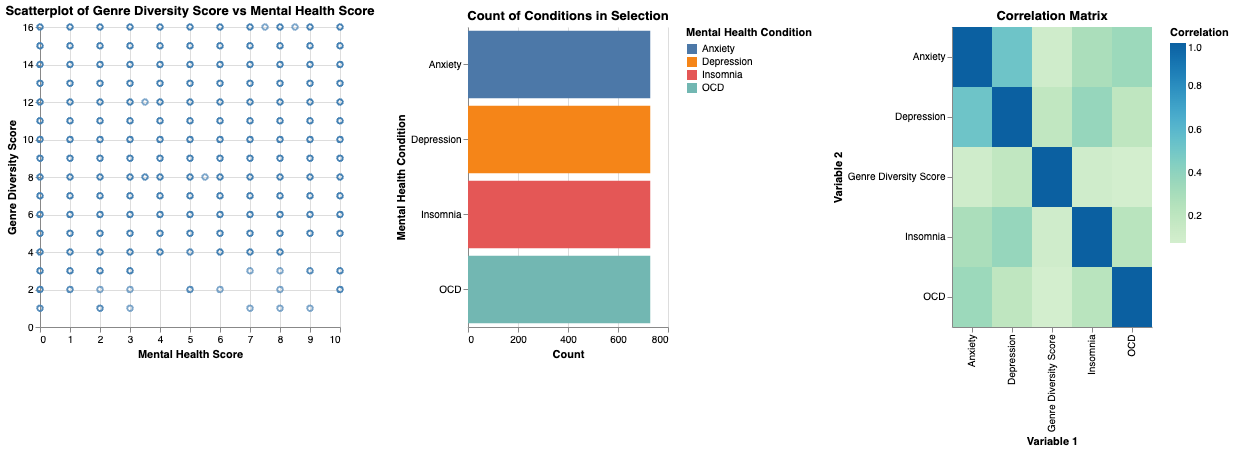

In [5]:
# Melt the dataset to long format
data_long = mxmh.melt(id_vars=["Genre Diversity Score"], 
                       value_vars=["Anxiety", "Depression", "Insomnia", "OCD"],
                       var_name="Mental Health Condition", value_name="Mental Health Score")

brush = alt.selection_interval()

# Scatter Plot with Brushing
points = alt.Chart(data_long).mark_point().encode(
    x='Mental Health Score:Q',
    y='Genre Diversity Score:Q',
    color=alt.condition(brush, alt.value("steelblue"), alt.value("lightgray")),
    tooltip=['Mental Health Condition:N', 'Mental Health Score:Q', 'Genre Diversity Score:Q']
).add_params(brush).properties(
    title="Scatterplot of Genre Diversity Score vs Mental Health Score"
)

# Aggregated Count Bar Chart with Tooltip
condition_counts = alt.Chart(data_long).mark_bar().encode(
    y=alt.Y('Mental Health Condition:N', title="Mental Health Condition"),
    x=alt.X('count():Q', title="Count"),
    color='Mental Health Condition:N',
).transform_filter(
    brush  
).properties(
    width=200, height=300, title="Count of Conditions in Selection"
)

# Compute Correlation Matrix
correlation_matrix = mxmh[['Genre Diversity Score', 'Anxiety', 'Depression', 'Insomnia', 'OCD']].corr().reset_index().melt(id_vars='index')
correlation_matrix.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Heatmap for Correlation Coefficients
correlation_chart = alt.Chart(correlation_matrix).mark_rect().encode(
    x='Variable 1:N',
    y='Variable 2:N',
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='greenblue'), title="Correlation"),
    tooltip=['Variable 1:N', 'Variable 2:N', 'Correlation:Q']  
).properties(
    width=200, height=300, title="Correlation Matrix"
)

task3_charts = alt.hconcat(
    points,
    condition_counts,
    correlation_chart
).resolve_scale(
    color='independent'
).configure_view(
    stroke=None
)

task3_charts